**Importing packages**

In [ ]:
# Normalization and Standartization imports
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

# Package for missing data
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, root_mean_squared_error

# Base packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

**Loading Testing and training datasets**

In [47]:
# Load datasets
trainning = pd.read_csv('trajnimi.csv')
testing = pd.read_csv('testimi.csv')

**Pre-processing**

In [ ]:
# Dropping the url column as it was not needed and caused errors if not removed further on
trainning.drop(trainning.columns[1], axis=1, inplace=True)
testing.drop(testing.columns[1], axis=1, inplace=True)

#print(trainning.columns.__len__())

Mean of Shares: 3412.369541226549
Standard Deviation of Shares: 11781.90589971156


In [50]:
# STEP 1: Remove articles with fewer than 5 words BEFORE splitting
initial_train_size = trainning.shape[0]
initial_test_size = testing.shape[0]

#trainning = trainning[trainning["shares"] <= 300000].copy() # first change, removing outlier for nr of shares above 300,000
trainning = trainning[trainning["shares"] <= 80000].copy()
trainning = trainning[trainning["n_tokens_content"] <= 4000].copy()
#trainning = trainning[trainning["kw_min_max"] <= 400000]
#trainning = trainning[trainning["kw_max_max"] <= 400000]
#trainning = trainning[trainning["self_reference_max_shares"] <= 400000]
#trainning = trainning[trainning["self_reference_max_shares"] <= 400000]
testing = testing[testing["n_tokens_content"] >= 10].copy()

removed_train = initial_train_size - trainning.shape[0]
#removed_test = initial_test_size - testing.shape[0]

print(f"\nArticles removed from training set: {removed_train}")
#print(f"Articles removed from testing set: {removed_test}")
print(f"Remaining training articles: {trainning.shape[0]}")
#print(f"Remaining testing articles: {testing.shape[0]}")

# STEP 2: Split the cleaned training data into training and validation
trainning, validation = train_test_split(trainning, test_size=0.1, random_state=42)

print("Mean of Shares:", trainning["shares"].mean())
print("Standard Deviation of Shares:", trainning["shares"].std())



Articles removed from training set: 0
Remaining training articles: 28450
Mean of Shares: 3048.235383714118
Standard Deviation of Shares: 5531.923223726824


**GRAPHS**

In [ ]:
# List of LDA topic features
lda_features = ["LDA_00", "LDA_01", "LDA_02", "LDA_03", "LDA_04"]

# Convert data into long format for better visualization
lda_melted = trainning.melt(id_vars=["shares"], value_vars=lda_features, var_name="LDA_Topic", value_name="Topic_Probability")

# Set plot size
plt.figure(figsize=(10, 6))

# Create a boxplot to show the distribution of shares for each topic
sns.boxplot(data=lda_melted, x="LDA_Topic", y="shares", palette="Set2")

# Enhance readability
plt.yscale("log")  # Use log scale to handle large variations in shares
plt.title("Distribution of Shares by LDA Topic")
plt.xlabel("LDA Topic")
plt.ylabel("Shares (log scale)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

**Correlation Analysis, Pearson/Spearman**

In [ ]:
# Compute correlation with shares
correlations = trainning.corr()["shares"].drop("shares").sort_values(ascending=False)

# Get top 5 most correlated features
top_5 = correlations.head(5)
print("Features most Correlated with Shares:")
print(top_5)

# Plot top correlated features
plt.figure(figsize=(8, 6))
sns.barplot(x=correlations.values[:10], y=correlations.index[:10], palette="coolwarm")
plt.xlabel("Correlation with Shares")
plt.title("Feature Importance via Correlation (Top 10)")
plt.show()


**TPOT**

In [ ]:
#gotta figure out this shit
from tpot import TPOTRegressor
# Define features and target
X = trainning.drop(columns=["shares"])  # Features
y = trainning["shares"]  # Target variable

standardscaler = StandardScaler()
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaled = standardscaler.fit_transform(X_train)
X_test_scaled = standardscaler.transform(X_test)

# Initialize TPOT for regression
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, n_jobs=-1)

# Train TPOT to find the best model
tpot.fit(X_train_scaled, y_train)

# Evaluate the best model on test data
score = tpot.score(X_test_scaled, y_test)
print("Best Model R² Score on Test Data:", score)

# Export the best pipeline
tpot.export("best_pipeline.py")


**TESTING**

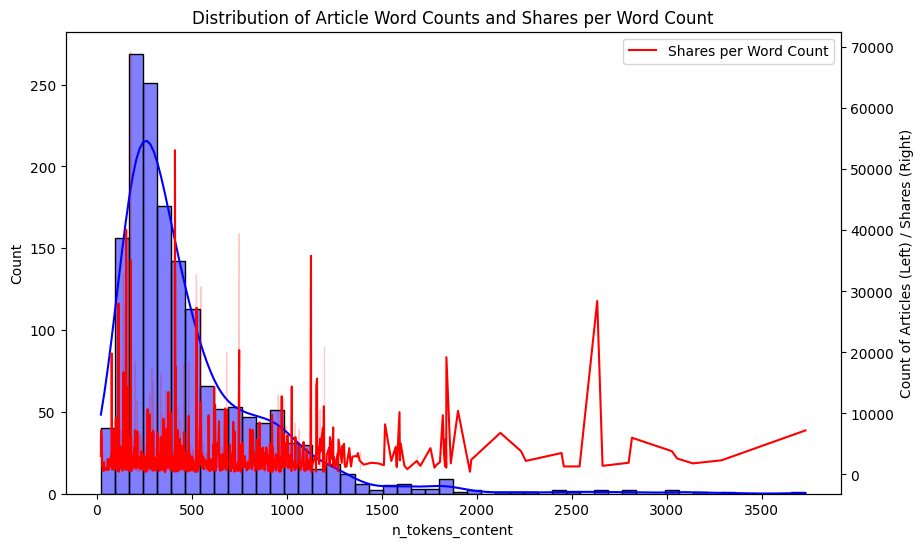

In [41]:
# Create the figure
plt.figure(figsize=(10, 6))

# Plot histogram of word counts
sns.histplot(trainning["n_tokens_content"], bins=50, kde=True, color="blue", label="Article Word Counts")

# Create a secondary y-axis for the shares trend
ax2 = plt.twinx()

# Plot the average shares per word count range
sns.lineplot(x=trainning["n_tokens_content"], y=trainning["shares"], color="red", ax=ax2, label="Shares per Word Count")

# Labels and title
plt.xlabel("Number of Words in Content")
plt.ylabel("Count of Articles (Left) / Shares (Right)")
plt.title("Distribution of Article Word Counts and Shares per Word Count")

# Legends
plt.legend(loc="upper right")

plt.show()


**CHECKING FOR ZERO WORD ARTICLES**

In [4]:
zero_word_articles = trainning[trainning['n_tokens_content'] == 0]
zero_word_count = len(zero_word_articles)

short_articles = trainning[trainning['n_tokens_content'] < 30]
short_articles_count = len(short_articles)

print(f"Number of articles with 0 words: {zero_word_count}")
print(f"Number of articles with less than 15 words: {short_articles_count}")


Number of articles with 0 words: 839
Number of articles with less than 15 words: 845


**OUTLIER CHECK - IQR METHOD**

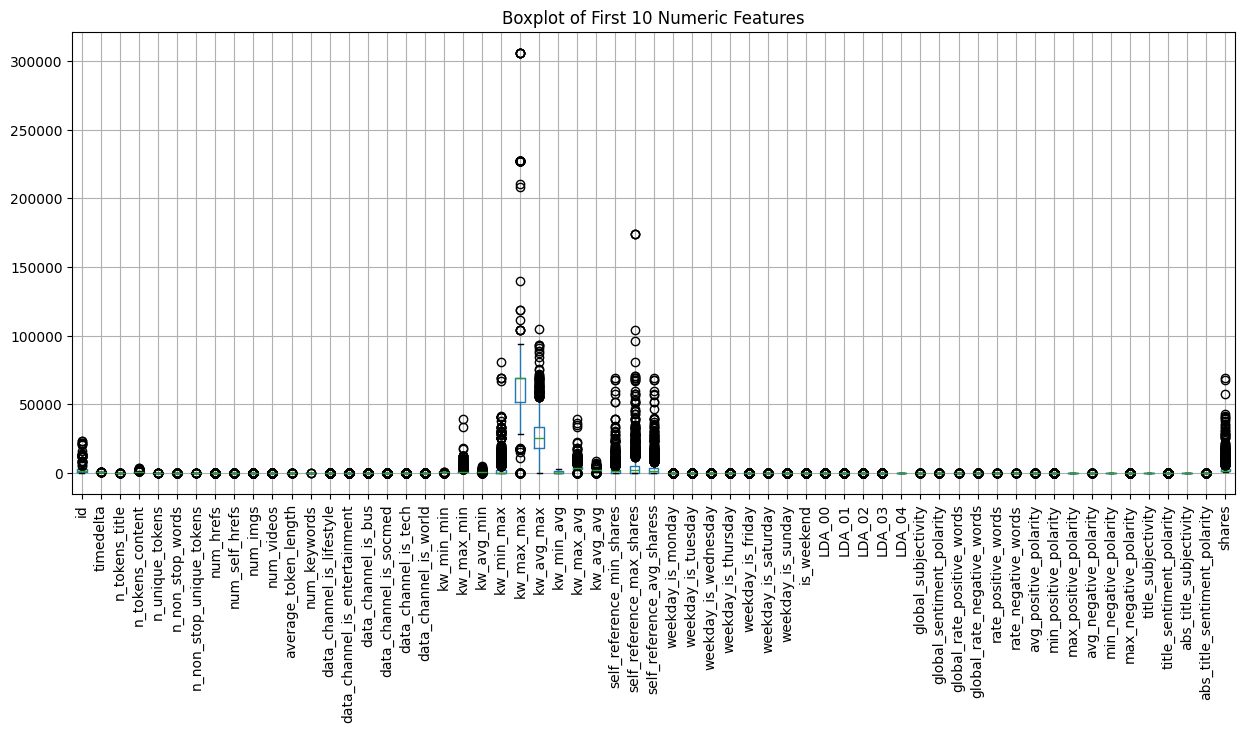

In [ ]:
# Select numeric columns only
numeric_cols = trainning.select_dtypes(include=['number']).columns

# Plot boxplots for the first 10 numeric features (to avoid overcrowding)
plt.figure(figsize=(15, 6))
trainning[numeric_cols[:]].boxplot(rot=90)  # Rotate x-axis labels for readability
plt.title("Boxplot of First 10 Numeric Features")
plt.show()


**Z-SCORE OUTLIER CHECK**

In [ ]:
from scipy import stats

# Function to remove outliers using Z-score for all columns
def remove_outliers_zscore(df, threshold=3):
    clean_df = df.copy()
    for col in df.select_dtypes(include=[np.number]).columns:
        z_scores = np.abs(stats.zscore(df[col]))
        clean_df = clean_df[z_scores < threshold]  # Keep only rows within threshold
    return clean_df

df_cleaned = remove_outliers_zscore(trainning)
print("Original Shape:", trainning.shape)
print("Cleaned Shape:", df_cleaned.shape)


**ISOLATION FOREST**

In [ ]:
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest on all numeric features
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso_forest.fit_predict(trainning.select_dtypes(include=[np.number]))

# Remove rows flagged as outliers (-1)
df_cleaned = trainning[outlier_labels != -1]

print("Original Shape:", trainning.shape)
print("Cleaned Shape:", df_cleaned.shape)


**Normalizer - Standardiser**

In [5]:
normalizer = Normalizer()
standard = StandardScaler()

**OUTLIER CHECKING**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of selected features for the boxplot
selected_features = [
    "n_unique_tokens", "average_token_length",
    "num_hrefs", "num_self_hrefs", "num_imgs", "num_videos",
    "weekday_is_saturday", "weekday_is_sunday", "is_weekend",
    "global_rate_positive_words", "global_rate_negative_words", "title_sentiment_polarity",
    "LDA_00", "LDA_01", "LDA_02", "LDA_03", "LDA_04"
]

# Filter dataset with selected features
data_to_plot = trainning[selected_features]

# Set plot size
plt.figure(figsize=(15, 8))

# Create boxplot for all selected features
sns.boxplot(data=data_to_plot)
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.title("Boxplot of Selected Features for Outlier Detection")
plt.show()


**Visualising data**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create a new column: Empty or Not
trainning["is_empty"] = trainning["n_tokens_content"] == 0

# Calculate average shares
avg_shares = trainning.groupby("is_empty")["shares"].mean()

# Plot
plt.figure(figsize=(6, 5))
sns.barplot(x=avg_shares.index, y=avg_shares.values, palette=["blue", "red"])
plt.xticks([0, 1], ["Articles with Words", "Articles with 0 Words"])
plt.ylabel("Average Shares")
plt.title("Do Empty Articles Get Fewer Shares?")
plt.show()



In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(trainning["n_tokens_content"], bins=50, kde=True)
plt.axvline(x=1, color='r', linestyle='--', label="1 Word Threshold")
plt.xlabel("Number of Words in Content")
plt.ylabel("Count of Articles")
plt.title("Distribution of Article Word Counts")
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=trainning)
plt.xticks(rotation=90)  # Rotate labels if needed
plt.title("Boxplot of Features (Outliers are points outside whiskers)")
plt.show()

#import seaborn as sns
#from matplotlib import pyplot as plt

#corr = trainning.corr()
#sns.heatmap(corr, annot=True)
#plt.show()


#sns.heatmap(trainning.isnull(), cmap="viridis", cbar=False, yticklabels=False)
#plt.show()

**Dimensionality reduction**

In [6]:
from sklearn.decomposition import TruncatedSVD

pca = PCA(n_components=2)
lda = LinearDiscriminantAnalysis(n_components=2)
svd = TruncatedSVD(n_components=2)

**Regression models**

In [7]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestNeighbors, KDTree, NearestCentroid
from sklearn import tree # decision tree and random forest
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor


# Ridge, Lasso and ElasticNet Regression
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Polynomial Regression (using PolynomialFeatures + Linear Regression)
from sklearn.preprocessing import PolynomialFeatures

# Support Vector Regression (SVR)
from sklearn.svm import SVR

In [8]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

In [9]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [10]:
linear_regression = LinearRegression() 

In [11]:
baysianRidge = BayesianRidge(alpha_1=0.001,alpha_2=1e-06 , lambda_1=1e-06, lambda_2= 0.001)

In [12]:
ridge = Ridge() 

In [13]:
lasso = Lasso() 

In [14]:
elasticnet = ElasticNet() 

In [15]:
svr = SVR(kernel='rbf', C=100, gamma=0.1)

In [16]:
logistic_reg = LogisticRegression()

In [17]:
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, RationalQuadratic
kernel1 = RBF(length_scale=1.0, length_scale_bounds=(1e-07, 1e3))
mattern = Matern()
dotproduct = DotProduct()
rationalQuadratic = RationalQuadratic()
gausian = GaussianProcessRegressor()

In [18]:
kernel_ridge = KernelRidge()

In [19]:
gaussionNB = GaussianNB()

In [ ]:
nearest_neigh = NearestNeighbors()

In [21]:
decision_tree = tree.DecisionTreeRegressor()

In [22]:
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)

**PIPELINE**

In [44]:
pca_components = [2, 15, 59]

models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "Decision Tree": tree.DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "MLP": MLPRegressor(max_iter=1000),
    "GaussianNB": GaussianNB(),
    #"Gaussian PR": GaussianProcessRegressor(),
    "Kernel Ridge": KernelRidge(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVR": SVR(),
    "ElasticNet": ElasticNet(),
    "Bayesian Ridge": BayesianRidge(),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
}

# saving the best results for each model
best_results = {}

# Evaluate models
#results =[]
for n in pca_components:
    
    best_score = float('inf')
    best_model = None
    best_model_name = None
    
    # Create pipeline with Normalizer and PCA
    for model_name, model in models.items():
        pipeline = Pipeline([
            ("normalizer", StandardScaler()),
            ("pca", PCA(n_components=n)),
            ("model", model)
        ])

        # Train and test
        pipeline.fit(trainning.drop('shares', axis=1), trainning['shares'])
        predictions = pipeline.predict(validation.drop('shares', axis=1))
        
        
        score = root_mean_squared_error(validation['shares'], predictions)  # RMSE
        
        if model_name not in best_results or score < best_results[model_name][1]:
            best_results[model_name] = (n, score, pipeline)
        #results[(model_name, n)] = score
        #print(f"{model_name} with {n} PCA components: {score}")

best_results_df = pd.DataFrame.from_dict(best_results, orient='index', columns=["Best PCA Components", "Best Score", "Best Model"])
print(best_results_df)

# Convert results to DataFrame
#results_df = pd.DataFrame.from_dict(results, orient='index', columns=["Score"])
#print(results_df)

c:\Users\aldo\Documents\work\machine_learning\aldo_diku\machine_learning_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\aldo\Documents\work\machine_learning\aldo_diku\machine_learning_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\aldo\Documents\work\machine_learning\aldo_diku\machine_learning_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


                     Best PCA Components  ...                                         Best Model
Linear Regression                     59  ...  (StandardScaler(), PCA(n_components=59), Linea...
Lasso                                 59  ...  (StandardScaler(), PCA(n_components=59), Lasso())
Ridge                                 59  ...  (StandardScaler(), PCA(n_components=59), Ridge())
Decision Tree                          2  ...  (StandardScaler(), PCA(n_components=2), Decisi...
Random Forest                         59  ...  (StandardScaler(), PCA(n_components=59), (Deci...
MLP                                    2  ...  (StandardScaler(), PCA(n_components=2), MLPReg...
GaussianNB                            59  ...  (StandardScaler(), PCA(n_components=59), Gauss...
Kernel Ridge                          59  ...  (StandardScaler(), PCA(n_components=59), Kerne...
Logistic Regression                   59  ...  (StandardScaler(), PCA(n_components=59), Logis...
SVR                           

**GRID SEARCH FOR MLP**

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Split features and target
X = trainning.drop(columns=["shares"])
y = trainning["shares"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data (MLPs perform better with normalized data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter grid
param_grid = {
    "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50)],
    "activation": ["relu", "tanh"],
    "solver": ["adam", "sgd"],
    "alpha": [0.0001, 0.001, 0.01, 0.1],  # Regularization
    "learning_rate": ["constant", "adaptive"]
}

# Initialize MLP Regressor
mlp = MLPRegressor(max_iter=1000, random_state=42)

# Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score (MSE):", grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test_scaled, y_test)
print("Test Set Score (R²):", test_score)


**Visualize performance of different models made in the pipeline**

In [ ]:
# Convert results dictionary to DataFrame
results_df = pd.DataFrame.from_dict(results, orient="index", columns=["Score"])

# Convert the index (which contains tuples of (model_name, PCA components)) into separate columns
results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=["Model", "PCA Components"])

# Reshape the DataFrame so models are rows and PCA components are columns
results_pivot = results_df.unstack(level=1)
results_pivot.columns = results_pivot.columns.droplevel(0)  # Remove extra level in columns

# Convert scores to full integers (remove decimals)
results_pivot = results_pivot.astype(int)

# Plot heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(results_pivot, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar=True)

# Customize plot
plt.title("Model Performance Across PCA Components")
plt.xlabel("Number of PCA Components")
plt.ylabel("Models")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Show plot
plt.show()


C:\Users\aldo\AppData\Local\Temp\ipykernel_13560\2606608229.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


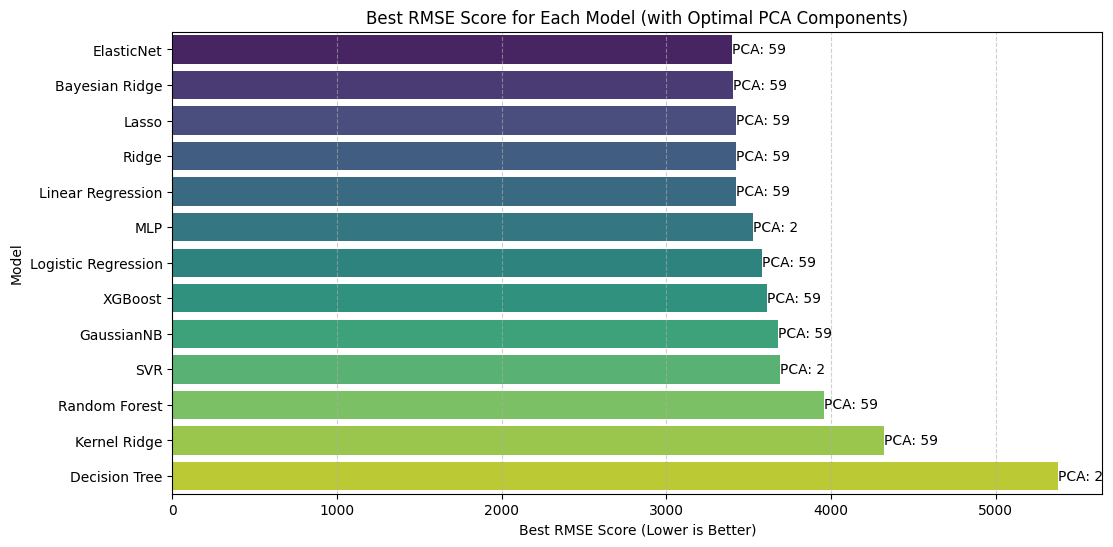

In [45]:
# Sort results by score (lower RMSE is better)
best_results_sorted = best_results_df.sort_values(by="Best Score")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    x=best_results_sorted["Best Score"], 
    y=best_results_sorted.index, 
    palette="viridis"
)

# Labels
plt.xlabel("Best RMSE Score (Lower is Better)")
plt.ylabel("Model")
plt.title("Best RMSE Score for Each Model (with Optimal PCA Components)")
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Annotate with PCA components
for index, value in enumerate(best_results_sorted["Best Score"]):
    pca_value = best_results_sorted.iloc[index]["Best PCA Components"]
    plt.text(value + 0.01, index, f"PCA: {pca_value}", va="center")

plt.show()


In [7]:
pipeline = Pipeline([
    ('normalizer', normalizer),
    ('pca', pca),
    ('model', linear_regression)
])

#training the model
pipeline.fit(trainning.drop('shares', axis=1), trainning['shares'])

#validating the model
predictions = pipeline.predict(validation.drop('shares', axis=1))

# the prediction, the lower the better
gabimi = root_mean_squared_error(validation['shares'], predictions)
print("Gabimi i validimit: ", gabimi)

#predictions = pipeline.predict(testing)
#predictions = pipeline.predict(testing[trainning.drop(columns=['shares']).columns])

Gabimi i validimit:  8521.826315180877


**Saving the predictions**

In [ ]:
def ruaj_parashikimet(id, parashikimet, emri):
    # Ensure both inputs are Pandas Series for safe indexing
    id = pd.Series(id).reset_index(drop=True)
    parashikimet = pd.Series(parashikimet).reset_index(drop=True)

    # Find the minimum length to avoid mismatch
    min_length = min(len(id), len(parashikimet))

    # Truncate both to the same length
    id = id.iloc[:min_length]
    parashikimet = parashikimet.iloc[:min_length]

    # Save to CSV
    df = pd.DataFrame({"id": id, "shares": parashikimet})
    df.to_csv(emri, index=False)
    print(f"Predictions saved to {emri} with {min_length} entries.")

# Ensure testing['id'] and predictions have matching lengths before passing them
ruaj_parashikimet(testing['id'], predictions, "parashikimet_reg.csv")



Predictions saved to parashikimet_reg.csv with 3077 entries.


In [ ]:
def ruaj_parashikimet(id, parashikimet, emri):
    """
    @param predikimet një listë me predikimet
    @param emri emri i skedarit për të ruajtur predikimet
    """
    trainning= pd.DataFrame(columns=['id', 'shares'])
    trainning['id'] = id
    trainning['shares'] = parashikimet
    trainning.to_csv(emri, index=False)

ruaj_parashikimet(testing['id'], predictions, "parashikimet_reg.csv")